In [16]:
import math
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import json
from datetime import datetime
import time
import numpy as np

def set_map_size(my_dpi):
    '''creates the map in the background. allows to determine dpi of the map'''
    plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)

def create_map():
    '''creates the map'''
    m = Basemap(projection='mill',llcrnrlat=25.1,urcrnrlat=71.5,\
            llcrnrlon=-10.5,urcrnrlon=87.3,resolution='c')
    m.drawcoastlines()
    m.shadedrelief()
    m.drawcountries()
    m.fillcontinents(color='#04BAE3', lake_color='#FFFFFF', zorder=0)
    m.drawmapboundary(fill_color='#FFFFFF')
    return m

def prepare_location_history(json_file):
    '''takes google location history and formats it so its data points can be evaluated'''
    # open and read json file into info:
    with open(json_file) as f:
        info = f.read()
    # reading the string into json and exstracting the actual location list (list contains dictionaries):
    info = json.loads(info)
    try:
        info = info["locations"] 
    except:
        pass
    # info = info[0::10] # NEEDS TO BE REMOVED ONCE COMPLETED. ONLY FOR QUICKNESS WHILE WORKING ON IT
    return info

def check_json_file(info):
    '''gives info about the json file used. needs "info" as argument'''
    print("about to plot %s data points..." %len(info))
    timestamps = [d['timestampMs'] for d in info]
    print("the oldest timestamp is from:", datetime.fromtimestamp(int(min(timestamps)) / 1000))
    print("the newest timestamp is from:", datetime.fromtimestamp(int(max(timestamps)) / 1000))

def plot_points(m, info):
    '''needs "lats" and "lons" list that can be obtained from evaluate_data function'''
    lx = []
    ly = []
    ihi = []
    for point in info:
        if not "altitude" in point:
            if len(ihi) <= 1:
                continue
            ihi.append(ihi[-1])
        else:
            if int(point["altitude"]) < 201:
                ihi.append('#fee5d9')
            elif int(point["altitude"]) < 501:
                ihi.append('#fcae91')
            elif int(point["altitude"]) < 1001:
                ihi.append('#fb6a4a')
            else: 
                ihi.append('#cb181d')
        x, y = m(point['longitudeE7'] / 10**7,point['latitudeE7'] / 10**7)
        lx.append(x)
        ly.append(y)
    plt.scatter(lx, ly, color=ihi, zorder=2)
    plt.plot(lx, ly, color='#fee5d9', marker='o', markersize=5.5, zorder=1)
    plt.title('Europe & parts of Asia, May to November 2018')
    return plt.show()

def calculate_distance(a, b):
    '''WORK IN PROGRESS.
    calculates distance between two data points. (radiant format). only gives a rough estimate as shape of earth is 
    ignored. not suitable for proper geoanalysis, but serves the purpose of eradicating outlier data points in the map'''
    E7 = math.sqrt((a["latitudeE7"] - b["latitudeE7"])**2 + (a["longitudeE7"] - b["longitudeE7"])**2)
    return E7 / 10**7

def find_extreme_altitudes(info):
    '''creates list with extreme altitude points from info'''
    newalts = []
    for entry in info:
        if "altitude" in entry:
            if entry["altitude"] <= min_alt:
                newalts.append(0)
            else:
                newalts.append(entry["altitude"])
        else:
            newalts.append(0)
    newalts.sort()
    return newalts[:10], newalts[len(newalts) - 10:] # returns one list with two lists in it - mins and maxs

In [18]:
from ast import literal_eval as make_tuple

def find_range_of_alts(info):
    '''returns the range in which the points move altitude-wise. necessary for good coloring'''
    minsmaxs = find_extreme_altitudes(info)
    mini = minsmaxs[0][0]
    maxi = minsmaxs[-1][-1]
    return abs(mini) + maxi

def find_range_of_colors(lightest_color, darkest_color):
    '''finds the range in which the rgb coloring has to happen (takes it from g )'''
    lightest = list(lightest_color)
    darkest = list(darkest_color)
    return abs(lightest[1] - darkest[1])

def find_point_color(altitude, change_color_after, darkest_color):
    '''returns the colorcode for each altitude. these can be inserdes in g and b'''
    times_11 = abs(altitude - mini) // change_color_after
    colorcode = darkest_color + times_11
    return colorcode

def create_colorcodes_by_altitude(info):
    '''returns list colorcodes (g (and b))'''
    colorcode_list = []
    
    for point in info:    
        
        if not "altitude" in point:
            if len(colorcode_list) <= 1:
                colorcode_list.append(0)
                continue
                
            colorcode_list.append(colorcode_list[-1])
            continue
        
        color = find_point_color(point["altitude"], change_color_after, 0)
        colorcode_list.append(color)
        
    return colorcode_list

def make_rgb_code(colorcode_list):
    final_colorcodes = []
    for i in colorcode_list:
        new = make_tuple("({}, {}, {})".format(1.0, i / 255.0, i / 255.0))
        final_colorcodes.append(new)
    return final_colorcodes

In [12]:
info = prepare_location_history("Standortverlauf_m_iran.json") # VIP THIS IS THE FILE I AM WORKING WITH FROM NOW

In [22]:
range_of_alts = find_range_of_alts(info)
print(range_of_alts)

li = (255, 204, 204)
da= (255, 0, 0) 

a = find_range_of_colors(li, da)
print(a)

change_color_after = range_of_alts // a
print(change_color_after)

2378
204
11


In [24]:
mini = find_extreme_altitudes(info)[0][0]

In [25]:
aaaa =  create_colorcodes_by_altitude(info)
print(max(aaaa))

ha = make_rgb_code(aaaa)

216


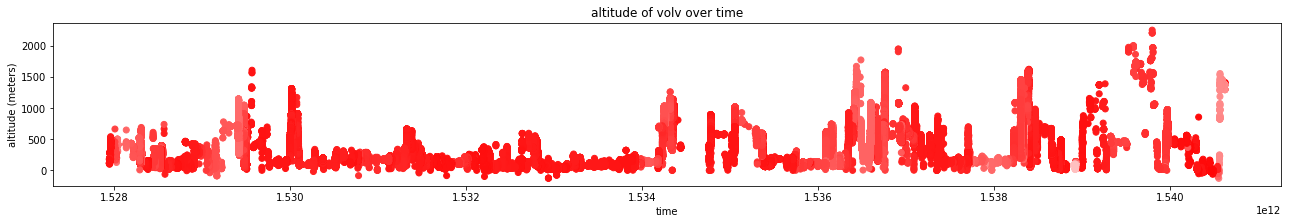

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# lowest point that can potentially be reached (caspian depression, kazakhstan)
min_alt = -138

timestamps = np.array([int(d['timestampMs']) for d in info if "altitude" in d if d['altitude'] > min_alt])
altitudes = np.array([d['altitude'] for d in info if "altitude" in d if d['altitude'] > min_alt]) # y-achse

fig, ax = plt.subplots()
fig.set_size_inches(22,3)
ax.set(xlabel='time', ylabel='altitude (meters)',
       title='altitude of volv over time')
plt.scatter(timestamps, altitudes, c=ha) # x, y